In [1]:
import pandas as pd
import numpy as np
import random
df = pd.read_csv("snacks.csv")

In this assignment, we are implementing Genetic Algorithm for solving knapsack problem.In the following cell, we can moodify constraints of the problem and also change some hyper parameters which are used in the GA such as some probabalites, number of generations, etc.We describe this parameters as follows:


1-numberOfSolutions = this is number of answers we generate initially

2-numberOfGeneratinos = this the number of times we apply cross over and mutation to our population

3-mutationProbabality = each time a new child is created as a result of crossOver, it is mutated with a probabality

4-parentPersistanceProb = each time a new child is created as a result of crossOver, there is a likelihood that parent survive in the population and child dies

In [2]:
upBound = 4
downBound = 1
maximumWeight = 10
minimumValue = 16
population = []
numberOfSolutions = 1000
numberOfGenerations = 300
mutationProbabality = 0.3
parentPersistenceProb = 0.4

At first we need to define chromosom and gene.Each chromosom is a solution to knapsack problem;thus each gene should be a knapsack item which keeps weight and value of a selected snack.The field key is a code which is further used to get name of the snack from csv file

In [3]:
class KnapsackItem:
    def __init__(self, key_, weight_, value_):
        self.key = key_
        self.value = value_
        self.weight = weight_

One important step in GA, is giving a point to each solution.we implement this functionality using fitness function such that it returns a higher number if the solution is a good suit for the problem and lower vice verca.In this problem, we have two parameters that can effect fitness of a solution;One is the total weight of the knapsack items and the other is total value of them.As we have some constraints for this two values, we can also inject these two constraints to get a better fitness.Obviosly it is better to have less weight and more value.The functionality of this idea is implemented in the following cell

In [4]:
def fitness(solution_):
    weightSum = 0
    valueSum = 0
    for item in solution_:
        weightSum += item.weight
        valueSum += item.value
    weightDifference = maximumWeight - weightSum
    valueDiffernce = valueSum - minimumValue
    if weightDifference * valueDiffernce > 0:
        return weightDifference + valueDiffernce
    else:
        if weightDifference > 0:
            return valueDiffernce
        else:
            return weightDifference

    

There are two alternatives in selection of parents in GA;One is assigning a selection probabality to each chromosom according to its fitness.The drawback of this method is that the chromosms with low fitnesses get slight chance to be selected as parents, despite having good genes.To solve this problem, there is a second alternative that we rank chromosoms according to their fitnesses and select them according to their indexes such that lower indexes have higher probability of being selected.In this alternative, chromosoms with very low fitnesses also have the chance of being selected.In the following cell, we implemented a function which selects an item from a list randomly according to its index.This function is further used in selecting parents for crossOver operation

In [5]:


def weighted_choice(items):
    weights = [1 / (i + 1) for i in range(len(items))]
    return random.choices(items, weights=weights, k=2)



The crossOver operation chooses a point randomly and merge two solutions from that point.An important thing to note is that this operation might disregard one of the constraints which is the variety of items.To avoid this problem, we check wether the variety is out of the range or not,if it is, we simply fix it by removing or adding a knapsack item to the solution

In [6]:
def crossOver(solution1, solution2):
    crossOverPoint = random.randint(1, len(solution1) - 1)
    solution_ = solution1[0:crossOverPoint] + solution2[crossOverPoint:]
    numberOfNonZeros = 0
    for item in solution_:
        if item.weight != 0:
            numberOfNonZeros += 1
    if numberOfNonZeros < downBound:
        for i in range(0, downBound - numberOfNonZeros):
            for item in solution_:
                if item.weight == 0:
                    item.weight = min(df.iloc[item.key, 1], abs(np.random.normal(df.iloc[item.key, 1] / 2, 1)))
                    item.value = (item.weight / df.iloc[item.key, 1]) * df.iloc[item.key, 2]
    elif numberOfNonZeros > upBound:
        diffrence = numberOfNonZeros - upBound
        while diffrence != 0:
            randomIndex = random.randint(0, len(df) - 1)
            if solution_[randomIndex].weight != 0:
                solution_[randomIndex].weight = 0
                solution_[randomIndex].value = 0
                diffrence -= 1                
    return solution_


To mutate a chromosom, we check its weight and value and simply upscale or downscale it to fit to the maximum weight.This operation is randomly done with a probablity on some chromosoms

In [7]:
def mutate(solution_):
    weightSum = 0
    for item in solution_:
        weightSum += item.weight
    if weightSum > maximumWeight and weightSum != 0:
        normalizationFactor = weightSum / maximumWeight
        for item in solution_:
            item.weight = item.weight / normalizationFactor
            item.value = item.value / normalizationFactor
    elif weightSum < maximumWeight and weightSum != 0:
        normalizationFactor = maximumWeight / weightSum
        for item in solution_:
            item.weight = item.weight * normalizationFactor
            item.value = item.value * normalizationFactor
    return solution_            



Finally we need to search through our population to see wether a solution is found.The below function implements this phase

In [8]:
def findSolution():
    for j in range(0, 1000):
        weightSum = 0
        valueSum = 0
        for item in population[j]:
            weightSum += item.weight
            valueSum += item.value
        if weightSum <= maximumWeight and valueSum >= minimumValue:
            return [population[j], True]
    return [0, False]              

This is where the algorithm begins.We first need to generate some answers randomly.To do so we first choose a random number which satisfies the variety constraint.Then we select items randomly according to number of items;Then for each item we create a weight using normal distribution.One hyper parameter that can be changed here is average and variance of the distribution.

In [9]:

for i in range(0, numberOfSolutions):
    numberOfItems = random.randint(downBound, upBound)
    itemsKey = sorted(random.sample(np.arange(len(df)).tolist(), numberOfItems))
    solution = []
    for j in range(0, len(df)):
        if j in itemsKey:
            randomWeight = min(df.iloc[j, 1], abs(np.random.normal(df.iloc[j, 1] / 2, 1)))
            value = (randomWeight / df.iloc[j, 1])*df.iloc[j, 2]
            solution.append(KnapsackItem(j, randomWeight, value))
        else:
            solution.append(KnapsackItem(j, 0, 0))   
    population.append(solution)
population = sorted(population, key = lambda x : fitness(x), reverse=True)

In this cell, different phases of GA are applied.To see the evolution of algorithm, we store average fitness of every generation and finally plot it to have better sense of how to change hyper parameters for a better suit

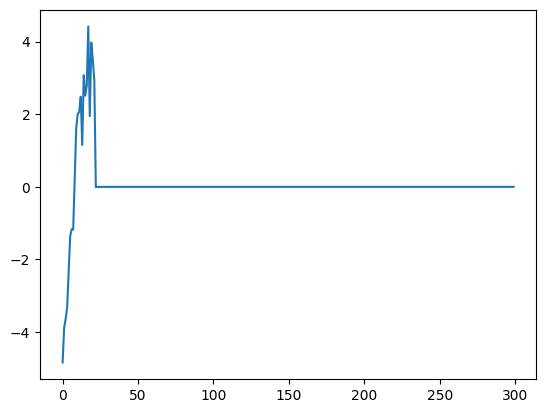

In [10]:
import matplotlib.pyplot as plt
averageValues = []
for i in range(0, numberOfGenerations):
    newPopulation = []
    for j in range(0, numberOfSolutions):
        parent1, parent2 = weighted_choice(population)
        newChild = crossOver(parent1, parent2)
        flag = random.choices([1, 2], weights=[abs(mutationProbabality), 1-abs(mutationProbabality)])
        if flag[0] == 1:
            newChild = mutate(newChild)
        flag = random.choices([1, 2], [parentPersistenceProb, 1 - parentPersistenceProb])
        if flag[0] == 1:
                if fitness(parent1) > fitness(parent2):
                    newPopulation.append(parent1)
                else:
                    newPopulation.append(parent2)
        else:                  
            newPopulation.append(newChild)
    population = newPopulation
    if i % 50 == 0:
        mutationProbabality = max(mutationProbabality - 0.1, 0)
    sorted(population, key = lambda x : fitness(x), reverse=True)
    averageValues.append(sum(fitness(sol) for sol in population) / len(population))    
plt.plot(averageValues)

If a solution is found, it will be displayed here:

In [11]:
finalAnswer = findSolution()
if finalAnswer[1]:
    for item in finalAnswer[0]:
        if item.weight != 0:
            print(df.iloc[item.key, 0], item.weight, item.value)

Jooj 10.0 21.428571428571388


In [12]:
for item in population[0]:
    if item.weight != 0:
        print(df.iloc[item.key, 0], item.weight, item.value)

Jooj 10.0 21.428571428571388


-Answers to Questions:

1-Low initial population can lead to some problems such as premature convergance(converging to a suboptimal solution too quickly without sufficiently exploring the search space) and limited exploration.High initial population can lead to slower execution and risk of lack of diversity


2-Increasing population in every iteration slows the algorithm down as the search space grows.But a larger population tends to improve the precision of the GA. With more individuals, the algorithm explores a broader portion of the search space. 

3-The GA is all about combining genes with the hope of getting better genes from parents and dropping their worse genes.The crossOver operation is the key operation to combine genes.But there's a likelihood that bad genes of parents be selected.To fix this the mutation comes in handy and tries to improve genes of a generated chromosom.So it is not wise to use only one of them and both of them should be used.

4-Generating inital population with less randomness and more porpusefully and trying to maintain constraints during crossOver and mutation operation.

5-The reason for which, chromosoms might not change, is that as we go ahead, chromosoms with lower fitnesses get lower likelihood of being selected and crossOver operation takes place only with some repeated chromosoms.To avoid this we can sort the chromsoms according to their fitness and then select them according to their index as described above the function wighted_choice

6-We can set a bound for number of generations and monitor the fitness average of population.when it deminishes, it is possibly not going to find any answer and hence should be terminated